In [1]:
#!pip3 install scikit-learn
#!pip3 install krippendorff
#!pip3 install diptest
#!pip3 install termcolor

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict, Counter
from itertools import chain, combinations
from random import seed, shuffle
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import roc_auc_score

from preprocess_classification_datasets import load_preprocessed_classification_data, preprocess_all_datasets
from classification import train_classifier, make_predictions, calculate_evaluation_metrics, characterize_mistakes_per_rating, characterize_mistakes_per_worker
from consensus import calculate_concensus

In [3]:
DATA_FOLDER = "../data/"

In [4]:
def print_table(results):
    table_text = ""
    table_text += "Rating"
    for key in sorted(results):
        table_text += " & {}".format(key)
    table_text += "\\\\\n"

    titles = ["Total num", "Fraction Misclassified", "Avg Prob Correct Class", "Std Of Prob Correct Class"]
    keys = ["num_instances", "frac_misclassified", "avg_prob", "std_prob"]

    for i, title in enumerate(titles):
        table_text += "{}".format(title)
        for key in sorted(results):
            table_text += " & {}".format(results[key][keys[i]])
        table_text += "\\\\\n"

    print(table_text)

In [5]:
def print_cdf(results):
    for i, j in results:
        print("{}, {}".format(i, round(j, 2)))

In [6]:
def demo():
    frac_train = 0.5
    random_seed = 560
    dataset_prefix = "AMT" # choose between "AMT", "AMT_wo_neutral", "SSI", "SSI_wo_neutral"
    data_subset = "test" # choose between "all", "train", "test"
    features = ['volitionality', 'reliability', 'privacy', 'relevance', 'causes_outcome', 'caused_by_sensitive_feature', 'causal_loop', 'causes_disparity_in_outcomes']
    control_features = ["fairness", "worker"]

    # load preprocessed dataset
    preprocess_all_datasets()
    data = load_preprocessed_classification_data(dataset_prefix, show_preview=False)


    # CLASSIFICATION
    # train & evaluate classifiers
    accuracy_cv, auc_cv = list(), list()
    for i in range(0, 5):
        random_seed -= 1
        # train classifier
        clsfr = train_classifier(data, features, control_features, frac_train=frac_train, random_seed=random_seed)    
        # make predictions
        ground_truth, predicted, predicted_prob, fairness_control, worker_control = make_predictions(clsfr, data, "test", features, control_features, frac_train=frac_train, random_seed=random_seed)    
        ## accuracy & auc
        accuracy, auc = calculate_evaluation_metrics(ground_truth, predicted)
        accuracy_cv.append(accuracy)
        auc_cv.append(auc)

    print("Average accuracy: ", np.average(np.array(accuracy_cv)))
    print("Average AUC: ", np.average(np.array(auc_cv)))

    # characterize misclassifications
    ## evaluate on whole data
    ground_truth, predicted, predicted_prob, fairness_control, worker_control = make_predictions(clsfr, data, "all", features, control_features, frac_train=frac_train, random_seed=random_seed)    
    
    ## missclassifications per fairness rating
    rating_mistakes = characterize_mistakes_per_rating(ground_truth, predicted, predicted_prob, fairness_control)
    print("\n\nCharacterize misclassifications per fairness rating\n")
    print_table(rating_mistakes)

    ## misclassifications per worker
    print("\n\nCharacterize misclassifications per worker (CDF)\n")
    worker_mistakes_cdf = characterize_mistakes_per_worker(ground_truth, predicted, worker_control)
    print_cdf(worker_mistakes_cdf)


    # CONSENSUS
    clsfr = train_classifier(data, features, control_features, frac_train=frac_train, random_seed=555)
    ground_truth, predicted, predicted_prob, fairness_control, worker_control = make_predictions(clsfr, data, "all", features, control_features, frac_train=frac_train, random_seed=random_seed)    
    data["predicted_fairness"] = predicted


    CRED = '\033[91m'
    CEND = '\033[0m'
    print(CRED + "########TEST TEST TEST START########")
    dict_data = data
    print(type(data))
    print(data)
    df_print = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in data.items() ]))
    df_print.to_excel('df_print.xlsx')
    with open('df_print.txt','w') as d: 
        d.write(str(data))
    print("########TEST TEST TEST END########" + CEND)
    
    
    concensus = calculate_concensus(data)
    
    

In [7]:
dict_data = {}
def main():
    demo()
         
    
if __name__=="__main__":
    main()

Average accuracy:  0.8989795918367347
Average AUC:  0.8974442441239316


Characterize misclassifications per fairness rating

Rating & 1 & 2 & 3 & 4 & 5 & 6 & 7\\
Total num & 391 & 249 & 195 & 136 & 321 & 280 & 388\\
Fraction Misclassified & 0.06 & 0.16 & 0.36 & 0.32 & 0.08 & 0.04 & 0.01\\
Avg Prob Correct Class & 0.89 & 0.75 & 0.58 & 0.61 & 0.81 & 0.9 & 0.97\\
Std Of Prob Correct Class & 0.19 & 0.25 & 0.28 & 0.29 & 0.2 & 0.15 & 0.08\\



Characterize misclassifications per worker (CDF)

0.0, 0.0
0.1, 0.0
0.2, 0.01
0.3, 0.01
0.4, 0.01
0.5, 0.02
0.6, 0.06
0.7, 0.12
0.8, 0.29
0.9, 0.6
1.0, 1.0
########TEST TEST TEST START########
<class 'dict'>
{'classification_features': ['volitionality', 'reliability', 'privacy', 'relevance', 'causes_outcome', 'caused_by_sensitive_feature', 'causal_loop', 'causes_disparity_in_outcomes', 'feature', 'worker'], 'continuous_features': ['volitionality', 'reliability', 'privacy', 'relevance', 'causes_outcome', 'caused_by_sensitive_feature', 'causal_loop', 'c

# CALCULATION SHANON ENTROPHY

In [8]:
import numpy as np
from math import log2
from scipy.stats import entropy

In [9]:
pk_CurrentCharges = np.array([0.01, 0.01, 0.01, 0.03, 0.12, 0.18, 0.65])  # fair coin
#pk_CurrentCharges

Hn = []
for i in pk_CurrentCharges:
    Hi = -i * log2(i)
    Hn.append(Hi)    
#print(Hn)

NSE= sum(Hn)/log2(7)
NSE

0.5583279782405884

In [10]:
1 - (entropy(pk_CurrentCharges) / np.log(len(pk_CurrentCharges)))

0.44208656301249816

In [11]:
pk2 = np.array([0.02, 0.01, 0.01, 0.03, 0.08, 0.22, 0.64])  # fair coin
pk2

Hn = []
for i in pk2:
    Hi = -i * np.log2(i)
    Hn.append(Hi)
    
SNE= 1- sum(Hn)/log2(7)
SNE

0.43659745046010345

In [12]:
pk2 = np.array([0.34, 0.22, 0.14, 0.08, 0.13, 0.06, 0.03])  # fair coin
pk2

Hn = []
for i in pk2:
    Hi = -i * np.log2(i)
    Hn.append(Hi)
    
SNE= 1- sum(Hn)/log2(7)
SNE

0.11792044152254089

In [13]:
#["entropy"] = scipy.stats.entropy(distribution)
#["normalized_entropy"] = 1 - (scipy.stats.entropy(distribution) / np.log(len(distribution)))

#["ternary_entropy"] = scipy.stats.entropy(ternary_distribution)
#["ternary_normalized_entropy"] = 1 - (scipy.stats.entropy(ternary_distribution) / np.log(len(ternary_distribution)))

In [14]:
#!pip3 install matplotlib

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
data_binary = [['AMT','included', 0.882, 0.879], 
        ['AMT','excluded', 0.905, 0.904],
        ['SSI','included', 0.872, 0.816],
        ['SSI','excluded', 0.878, 0.852]
       ]
df_binary = pd.DataFrame(data_binary, columns=['Sample', 'Neutral Judgments', 'Accuracy', 'AUC'])
df_binary = df_binary.set_index('Sample')
df_binary

,Neutral Judgments,Accuracy,AUC
Sample,,,
AMT,included,0.882,0.879
AMT,excluded,0.905,0.904
SSI,included,0.872,0.816
SSI,excluded,0.878,0.852


In [16]:
df_binary_excluded = df_binary[df_binary['Neutral Judgments']== 'excluded']
df_binary_excluded = df_binary_excluded.drop(['Neutral Judgments'], axis=1)
df_binary_excluded

,Accuracy,AUC
Sample,,
AMT,0.905,0.904
SSI,0.878,0.852


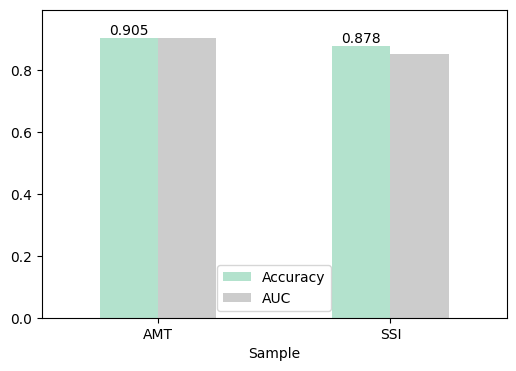

In [17]:
ax = df_binary_excluded.plot(kind='bar',figsize=(6,4), rot = 0, colormap = 'Pastel2')
ax.legend(loc=0)#, bbox_to_anchor=(1, 0.5)
ax.bar_label(ax.containers[0], label_type='edge') # annotate
ax.margins(y=0.1)# pad the spacing between the number and the edge of the figure
ax.get_figure().savefig('df_binary_excluded.jpeg' ,dpi=600);

In [18]:
df_binary_included = df_binary[df_binary['Neutral Judgments']== 'included'] 
df_binary_included = df_binary_included.drop(['Neutral Judgments'], axis=1)
df_binary_included

,Accuracy,AUC
Sample,,
AMT,0.882,0.879
SSI,0.872,0.816


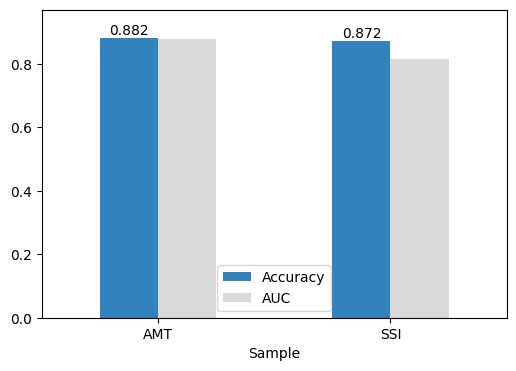

In [19]:
ax = df_binary_included.plot(kind='bar', figsize=(6,4), rot = 0, colormap = 'tab20c')
ax.legend(loc=0)#, bbox_to_anchor=(1, 0.5)
ax.bar_label(ax.containers[0], label_type='edge') # annotate
ax.margins(y=0.1)# pad the spacing between the number and the edge of the figure
ax.get_figure().savefig('df_binary_included.jpeg' ,dpi=600);

In [20]:
import pandas as pd

test_data = pd.read_excel(r'/Users/nursatkakon/Library/CloudStorage/OneDrive-TUNI.fi/23_Spring 2023/DATA.ML.381 Fairness in Big Data Management/Fairness in BDM/project_code/code/test.xlsx')
#test_data = test_data.set_index('worker')
test_data['class_label'] = test_data['class_label'].replace(-1, 0)
test_data['predicted_fairness'] = test_data['predicted_fairness'].replace(-1, 0)


test_data

,worker,class_label,fairness,feature,volitionality,reliability,privacy,relevance,causes_outcome,caused_by_sensitive_feature,causal_loop,causes_disparity_in_outcomes,predicted_fairness
0,0,1,7,the_defendant's_current_criminal_charge,1,7,1,7,6,1,7,1,1
1,0,1,7,the_defendant's_criminal_history,1,7,1,7,6,2,7,4,1
2,0,1,4,the_criminal_history_of_the_defendant's_family...,2,6,3,5,4,4,4,4,1
3,0,1,7,the_defendant's_history_of_substance_abuse,7,6,1,6,7,1,7,1,1
4,0,1,5,the_stability_of_the_defendant's_employment_an...,5,5,4,5,5,2,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,199,1,5,the_safety_of_the_neighborhood_the_defendant_l...,5,5,2,5,5,5,4,6,1
1956,199,1,4,the_defendant's_education_and_behavior_in_school,2,5,4,2,3,1,3,2,0
1957,199,0,3,the_quality_of_the_defendant's_social_life_and...,7,3,6,3,2,2,6,2,0
1958,199,1,6,the_defendant's_personality,6,5,3,6,5,2,3,2,1


In [21]:
#!pip3 install seaborn
#!pip3 install statsmodels 
import seaborn as sns

In [22]:
z = (test_data['relevance'].value_counts()).to_dict()
test_data['relevance_count'] = test_data['relevance'].map(z) 
#test_data
test_data['relevance'].value_counts()
test_data['privacy'].value_counts()

1    463
2    345
4    253
5    238
6    231
3    221
7    209
Name: privacy, dtype: int64

/opt/anaconda3/envs/r-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


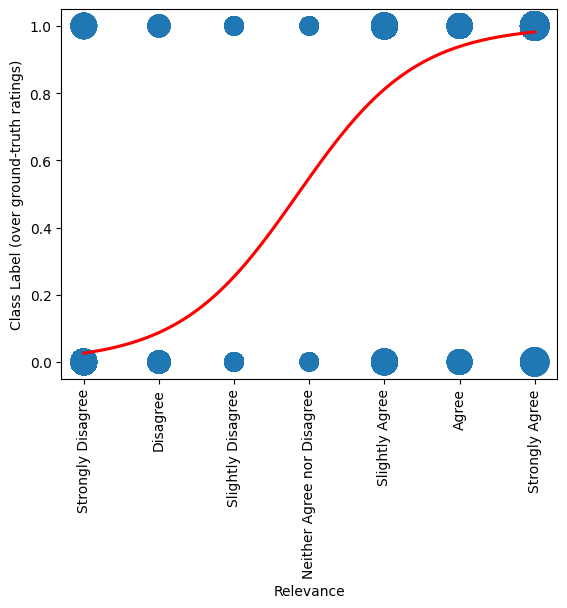

In [23]:
ax = sns.regplot(x=test_data['relevance'], y=test_data['class_label'], data=test_data, logistic=True, ci=None,
            scatter_kws={'s': test_data['relevance_count']}, line_kws={'color': 'red'}) #scatter_kws={'color': 'blue'}


ax.set_xticklabels(['', 'Strongly Disagree', 'Disagree', 
                    'Slightly Disagree','Neither Agree nor Disagree',
                    'Slightly Agree', 'Agree', 'Strongly Agree'], rotation=90)

ax.set(xlabel='Relevance', ylabel='Class Label (over ground-truth ratings)')
ax.get_figure().savefig('Relevance_curve.jpeg' ,dpi=600);


In [24]:
z = (test_data['privacy'].value_counts()).to_dict()
test_data['privacy_count'] = test_data['privacy'].map(z) 
test_data

,worker,class_label,fairness,feature,volitionality,reliability,privacy,relevance,causes_outcome,caused_by_sensitive_feature,causal_loop,causes_disparity_in_outcomes,predicted_fairness,relevance_count,privacy_count
0,0,1,7,the_defendant's_current_criminal_charge,1,7,1,7,6,1,7,1,1,409,463
1,0,1,7,the_defendant's_criminal_history,1,7,1,7,6,2,7,4,1,409,463
2,0,1,4,the_criminal_history_of_the_defendant's_family...,2,6,3,5,4,4,4,4,1,334,221
3,0,1,7,the_defendant's_history_of_substance_abuse,7,6,1,6,7,1,7,1,1,308,463
4,0,1,5,the_stability_of_the_defendant's_employment_an...,5,5,4,5,5,2,4,1,1,334,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,199,1,5,the_safety_of_the_neighborhood_the_defendant_l...,5,5,2,5,5,5,4,6,1,334,345
1956,199,1,4,the_defendant's_education_and_behavior_in_school,2,5,4,2,3,1,3,2,0,242,253
1957,199,0,3,the_quality_of_the_defendant's_social_life_and...,7,3,6,3,2,2,6,2,0,173,231
1958,199,1,6,the_defendant's_personality,6,5,3,6,5,2,3,2,1,308,221


/opt/anaconda3/envs/r-tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


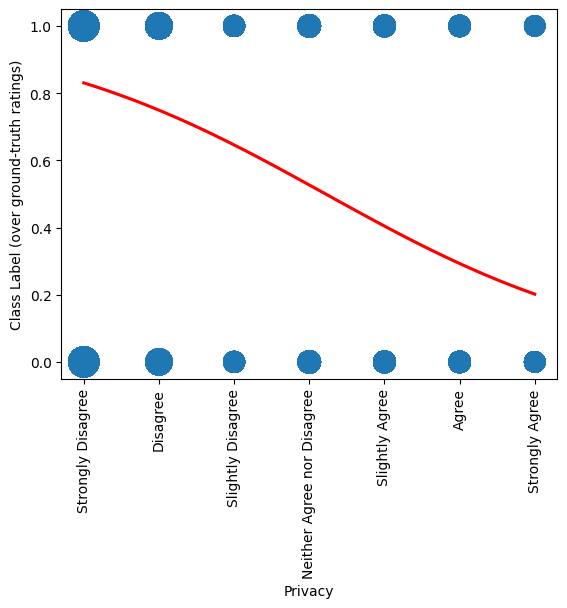

In [25]:
ax = sns.regplot(x=test_data['privacy'], y=test_data['class_label'], data=test_data, logistic=True, ci=None,
            scatter_kws={'s': test_data['privacy_count']}, line_kws={'color': 'red'})

ax.set_xticklabels(['', 'Strongly Disagree', 'Disagree', 
                    'Slightly Disagree','Neither Agree nor Disagree',
                    'Slightly Agree', 'Agree', 'Strongly Agree'], rotation=90)

ax.set(xlabel='Privacy', ylabel='Class Label (over ground-truth ratings)')
ax.get_figure().savefig('Privacy_curve.jpeg' ,dpi=1000);

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
data_OR = [['Reliability', 1.27],
               ['Relevance',2.47], 
               ['Privacy',0.95], 
               ['Volitionality',1.18 ], 
               ['Causes Outcome',1.29], 
               ['Vicious Cycle',0.84],
               ['Causes Disparity',0.95],
               ['Caused by Sensitive', 1.03 ]]
data_OR = pd.DataFrame(data_OR, columns=['Latent Properties', 'Odds Ratio'])
data_OR = data_OR.set_index('Latent Properties')
data_OR

,Odds Ratio
Latent Properties,
Reliability,1.27
Relevance,2.47
Privacy,0.95
Volitionality,1.18
Causes Outcome,1.29
Vicious Cycle,0.84
Causes Disparity,0.95
Caused by Sensitive,1.03


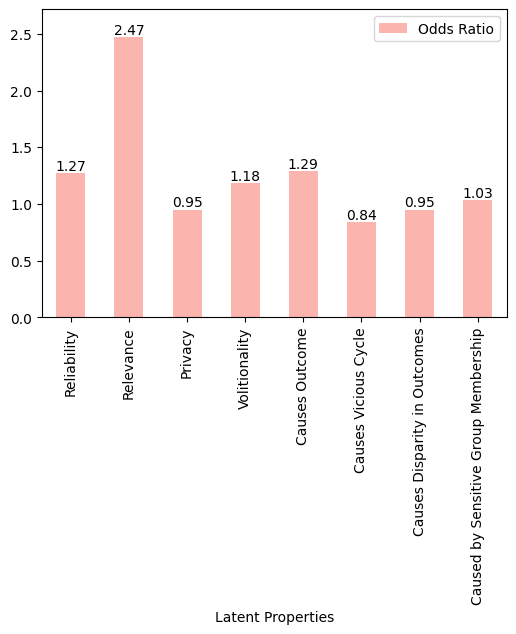

In [27]:
ax = data_OR.plot(kind='bar', figsize=(6,4), rot = 0, colormap = 'Pastel1')
ax.legend(loc=0)#, bbox_to_anchor=(1, 0.5)
ax.bar_label(ax.containers[0], label_type='edge') # annotate
ax.margins(y=0.1)# pad the spacing between the number and the edge of the figure
ax.set_xticklabels(['Reliability', 'Relevance', 'Privacy','Volitionality',
                    'Causes Outcome', 'Causes Vicious Cycle', 'Causes Disparity in Outcomes', 'Caused by Sensitive Group Membership'], rotation=90)
ax.get_figure().savefig('data_OR.jpeg' ,dpi=600);